In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

import warnings
warnings.filterwarnings('ignore')

## ENSEMBLE QUANTILE from the Mean of Weibull Parameters Satellites

In [2]:
npix = 5

yy_s, yy_e = 2002, 2012
# yy_s, yy_e = 2002, 2023

year_vector = np.arange(yy_s, yy_e+1)
years_num = yy_e - yy_s + 1
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [4]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_500.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [5]:
OBS_base = os.path.join(dir_base,'stations','data')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'Weibull','Veneto_INFO.csv')

if os.path.exists(OBS_INFO_dir):
    wa_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

In [6]:
total_years = np.arange(1980,2024)
print(f'Quantiles for period: {1980} to {2024}')
N_array = np.zeros([len(wa_pd),len(total_years)])
C_array = np.zeros([len(wa_pd),len(total_years)])
W_array = np.zeros([len(wa_pd),len(total_years)])

for nn in range(len(wa_pd)):
    filename = f'{wa_pd['File_Name'].values[nn]}.csv'
    Weibull_OBS = pd.read_csv(os.path.join(OBS_base,'Weibull','Veneto',filename))

    for count, YY in enumerate(total_years):
        N_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['N'].values
        C_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['C'].values
        W_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['W'].values
        if len(N_) == 0:
            N_array[nn,count] = np.nan
            C_array[nn,count] = np.nan
            W_array[nn,count] = np.nan
        else:
            if N_[0] == 0:
                N_array[nn,count] = np.nan
                C_array[nn,count] = np.nan
                W_array[nn,count] = np.nan
            else:
                N_array[nn,count] = float(N_[0])
                C_array[nn,count] = float(C_[0])
                W_array[nn,count] = float(W_[0])

Quantiles for period: 1980 to 2024


In [7]:
print(f'Extract Parameters for: {yy_s} to {yy_e}')
N_df = pd.DataFrame(data=N_array,columns=total_years)
N_df = N_df.loc[:,yy_s:yy_e]
N_df.insert(0, 'filename', wa_pd['File_Name'].values)
N_df.insert(1, 'Lat', wa_pd['Lat'].values)
N_df.insert(2, 'Lon', wa_pd['Lon'].values)

C_df = pd.DataFrame(data=C_array,columns=total_years)
C_df = C_df.loc[:,yy_s:yy_e]
C_df.insert(0, 'filename', wa_pd['File_Name'].values)
C_df.insert(1, 'Lat', wa_pd['Lat'].values)
C_df.insert(2, 'Lon', wa_pd['Lon'].values)

W_df = pd.DataFrame(data=W_array,columns=total_years)
W_df = W_df.loc[:,yy_s:yy_e]
W_df.insert(0, 'filename', wa_pd['File_Name'].values)
W_df.insert(1, 'Lat', wa_pd['Lat'].values)
W_df.insert(2, 'Lon', wa_pd['Lon'].values)

Extract Parameters for: 2002 to 2012


In [8]:
N_df.head(3)

,filename,Lat,Lon,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,002_FG_BS,45.895600,12.815000,109.0,69.0,95.0,86.0,77.0,81.0,111.0,94.0,107.0,72.0,84.0
1,003_BL_Ar,46.499984,11.876073,133.0,85.0,103.0,103.0,109.0,100.0,131.0,104.0,112.0,98.0,118.0
2,003_FG_BS,45.918000,12.545000,105.0,70.0,102.0,91.0,84.0,79.0,109.0,105.0,111.0,76.0,83.0


In [9]:
Tr = np.array([10, 20, 50, 100, 200])
Fi = 1 - 1/Tr
Q_obs = np.zeros([len(wa_pd), len(Tr)])
File_, Lat_, Lon_, YYS_, YYE_, NY_ = [], [], [], [], [], []

for nn in range(len(wa_pd)):
    N_ = N_df.loc[:,yy_s:yy_e].values[nn]
    C_ = C_df.loc[:,yy_s:yy_e].values[nn]
    W_ = W_df.loc[:,yy_s:yy_e].values[nn]

    File_.append(wa_pd['File_Name'][nn])
    Lat_.append(wa_pd['Lat'][nn])
    Lon_.append(wa_pd['Lon'][nn])
    YYS_.append(yy_s)
    YYE_.append(yy_e)
    NY_.append(years_num - np.sum(np.isnan(N_)))

    x0 = np.nanmean(C_)
    TMP_Q, flags = ART_down.mev_quant_update(Fi, x0, N_, C_, W_, thresh=1)
    TMP_Q = np.where(flags==True,TMP_Q,np.nan)
    Q_obs[nn,:] = TMP_Q

new_df = pd.DataFrame(Q_obs, columns=['Q10','Q20','Q50','Q100','Q200'])
new_df.insert(0, 'File_Name', File_)
new_df.insert(1, 'Lat', Lat_)
new_df.insert(2, 'Lon', Lon_)
new_df.insert(3, 'YYS', YYS_)
new_df.insert(4, 'YYE', YYE_)
new_df.insert(5, 'NY', NY_)

clear_df = new_df[new_df['NY']==years_num]
clear_df = new_df[new_df['NY'] == years_num].reset_index(drop=True)

In [10]:
frac = 0.8

Q_80 = clear_df.sample(frac=frac, random_state=42)
Q_80 = Q_80.reset_index(drop=True)

Q_20 = clear_df.drop(Q_80.index)
Q_20 = Q_20.reset_index(drop=True)

print(f'Number of Stations: {len(clear_df)}')
print(f'80% DataFrame: {len(Q_80)}')
print(f'20% DataFrame: {len(Q_20)}')

Number of Stations: 200
80% DataFrame: 160
20% DataFrame: 40


In [11]:
# Manual remove for strange station
wa_filter = Q_80[Q_80['Q50']<=600]
# wa_filter = Q_80[Q_80['Q50']<=380]
wa_filter = wa_filter.reset_index(drop=True)

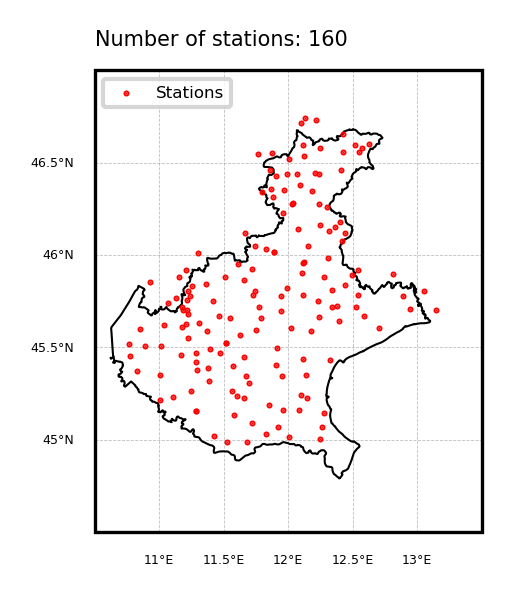

In [12]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(2,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

ax1.scatter(Q_80['Lon'].values, Q_80['Lat'].values, s=0.2, c='r', zorder=20, label='Stations')

plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True

gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title(f'Number of stations: {len(Q_80)}', loc='left', fontsize=5)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [13]:
index_station = 30

In [14]:
OBS_Q = Q_80.iloc[index_station][6:].values

lat_station = Q_80['Lon'].values[index_station]
lon_station = Q_80['Lat'].values[index_station]

print(f'Lon: {lon_station}')
print(f'Lat: {lat_station}')

Lon: 46.3131289
Lat: 11.88273666


In [15]:
data_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [32]:
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_ERA5_3h_{yy_s}_{yy_e}_npix_5_FD.nc')
DATA = xr.open_dataset(data_dir)

lon_ERA5, lat_ERA5  = np.meshgrid(DATA.lon.values, DATA.lat.values)

Tr_val = DATA['Tr'].values

ERA5_N = DATA['N'].values
ERA5_Nd = DATA['Nd'].values

QERA5 = DATA.Q.values
QdERA5 = DATA.Qd.values
# del DATA
QERA5.shape

(6, 11, 13)

In [17]:
distances = ART_pre.haversine(lat_ERA5, lon_ERA5, lat_station, lon_station)
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

ERA5_Q = QERA5[1:,min_index[0],min_index[1]]
ERA5_Qd = QdERA5[1:,min_index[0],min_index[1]]

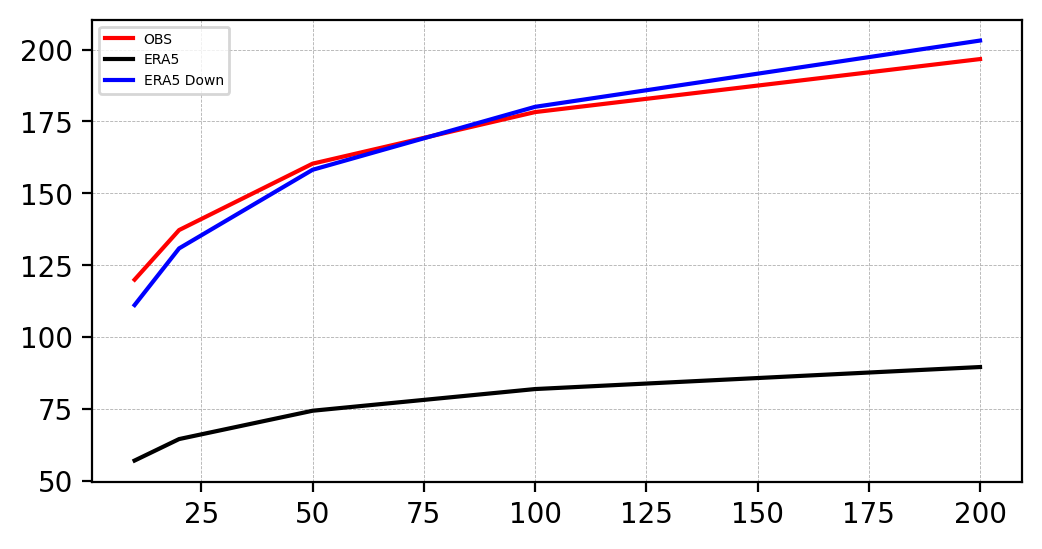

In [18]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(Tr_val[1:], OBS_Q, c='r', label='OBS')
ax1.plot(Tr_val[1:], ERA5_Q, c='k', label='ERA5')
ax1.plot(Tr_val[1:], ERA5_Qd, c='b', label='ERA5 Down')
ax1.legend(fontsize=5)
ax1.grid(linewidth=0.3, linestyle='--')

In [19]:
E_Q = []
E_Qd = []
for index_station in range(len(wa_filter)):#len(OBS_Q)
    OBS_50Q = wa_filter.iloc[index_station]['Q50']
    lat_station = wa_filter['Lon'].values[index_station]
    lon_station = wa_filter['Lat'].values[index_station]
    
    distances = ART_pre.haversine(lat_ERA5, lon_ERA5, lat_station, lon_station)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    ERA5_Q = QERA5[3,min_index[0],min_index[1]]
    ERA5_Qd = QdERA5[3,min_index[0],min_index[1]]
    
    ERROR_ = (ERA5_Q - OBS_50Q)/OBS_50Q
    E_Q.append(ERROR_)

    ERROR_ = (ERA5_Qd - OBS_50Q)/OBS_50Q
    E_Qd.append(ERROR_)


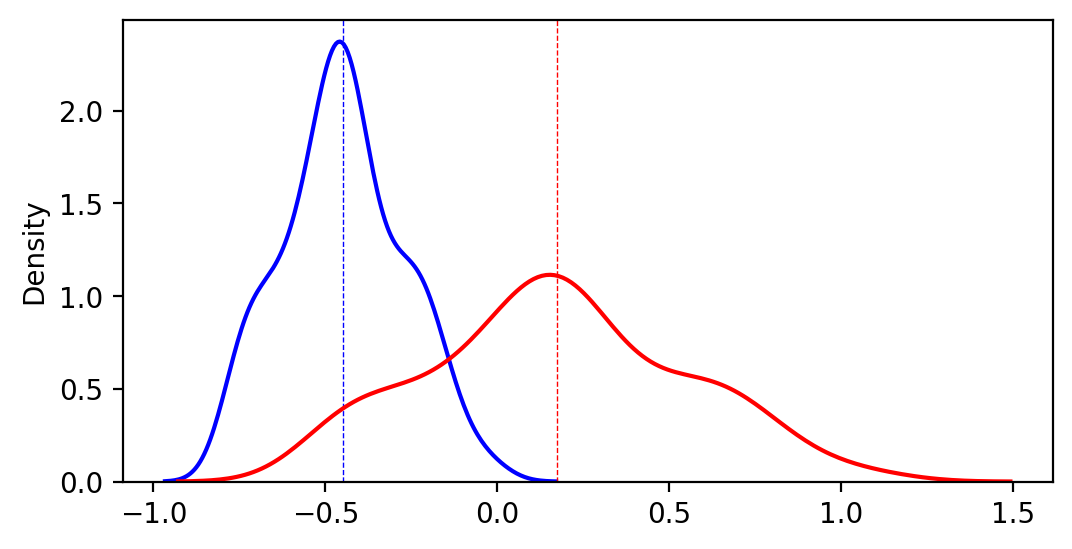

In [20]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(E_Q,color='b',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5')
ax1.axvline(np.nanmean(E_Q), color='b', linestyle='--', linewidth=0.5, label='ERA5 mean')

sns.kdeplot(E_Qd,color='r',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5D')
ax1.axvline(np.nanmean(E_Qd), color='r', linestyle='--', linewidth=0.5, label='ERA5D mean')


In [22]:
N_df

,filename,Lat,Lon,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,002_FG_BS,45.895600,12.815000,109.0,69.0,95.0,86.0,77.0,81.0,111.0,94.0,107.0,72.0,84.0
1,003_BL_Ar,46.499984,11.876073,133.0,85.0,103.0,103.0,109.0,100.0,131.0,104.0,112.0,98.0,118.0
2,003_FG_BS,45.918000,12.545000,105.0,70.0,102.0,91.0,84.0,79.0,109.0,105.0,111.0,76.0,83.0
3,004-264_NP_Be,46.164679,12.244708,119.0,86.0,115.0,96.0,90.0,86.0,129.0,112.0,108.0,99.0,102.0
4,004_NP_Be,46.133632,12.195395,119.0,86.0,103.0,104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,346_NP_La,46.129873,12.318301,107.0,37.0,96.0,92.0,78.0,53.0,128.0,109.0,107.0,90.0,94.0
251,348_NP_Ro,46.190733,12.407890,118.0,76.0,105.0,97.0,93.0,94.0,126.0,109.0,95.0,98.0,105.0
252,349_NP_Tr,45.663472,12.237917,59.0,63.0,99.0,76.0,68.0,71.0,105.0,85.0,102.0,68.0,69.0
253,350_NP_Va,45.862455,11.659233,64.0,80.0,112.0,111.0,67.0,81.0,119.0,110.0,103.0,86.0,90.0


In [48]:
OBS_N_all = []
ERA5_N_all = []
ERA5_Nd_all = []

for index_station in range(len(N_df)):#len(N_df)
    lat_station = N_df['Lon'].values[index_station]
    lon_station = N_df['Lat'].values[index_station]

    OBS_N_ = N_df.iloc[index_station][3:].values
    OBS_N_all.append(OBS_N_)
    
    distances = ART_pre.haversine(lat_ERA5, lon_ERA5, lat_station, lon_station)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    ERA5_N_ = ERA5_N[:,min_index[0],min_index[1]]
    ERA5_N_all.append(ERA5_N_)
    
    ERA5_Nd_ = ERA5_Nd[:,min_index[0],min_index[1]]
    ERA5_Nd_all.append(ERA5_Nd_)

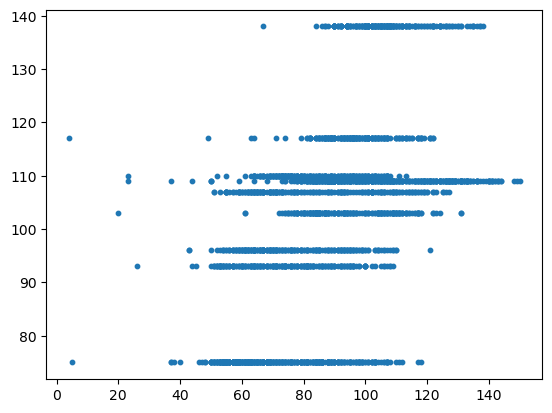

In [49]:
plt.scatter(OBS_N_all,ERA5_N_all,s=10)

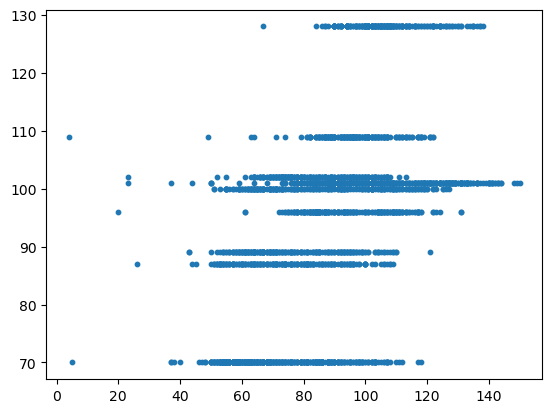

In [50]:
plt.scatter(OBS_N_all,ERA5_Nd_all,s=10)

In [29]:
N_OBS_vals

array([np.float64(109.0), np.float64(69.0), np.float64(95.0),
       np.float64(86.0), np.float64(77.0), np.float64(81.0),
       np.float64(111.0), np.float64(94.0), np.float64(107.0),
       np.float64(72.0), np.float64(84.0)], dtype=object)